# Pressure, Tested with Jupiter-like Conditions
Scrapping the old pressure test and rewriting from scratch

### Notes
* It looks like the Y matrix values are opposite. I should probably multiply by -1.
* gradW should be returning values on the order of e-35
* Current values of dt and h are not finalized
* gradW for the interval between 1 and 2 returns higher magnitude values that gradW for the interval below 1

### Imports

In [53]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb

Populating the interactive namespace from numpy and matplotlib


### Constants

In [54]:
dt = 1e-2
stepN = 100

### Initialize position, velocity, mass, pressure, density, and time

In [55]:
### --- Distribution Case 1 --- ###
# xyDistribution = np.array(([1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8])) 
# nParticles = len(xyDistribution)

### --- Distribution Case 1.5 --- ###
xyDistribution = np.array(([1.0e8, 1.0e8], 
                           [-1.0e8, -5.0e8],
                           [0.0, 1.0e8]))
nParticles = len(xyDistribution)

### --- Distribution Case 2 --- ###
# nParticles = 250
# xyDistribution = np.random.normal(0,5e7, size=(nParticles, 2))

# Velocity and mass distribution
velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 2e27

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))


timeArray = np.arange(0, stepN*dt, dt)

[]

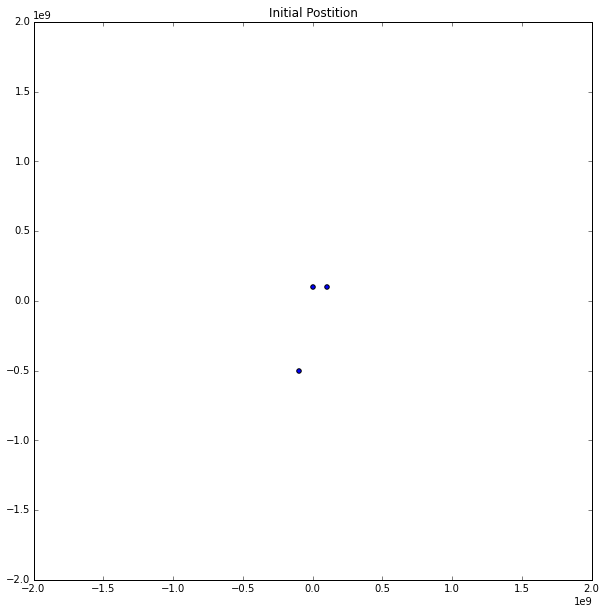

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2e9, 2e9)
plt.ylim(-2e9, 2e9)
plt.title("Initial Postition")
plt.plot()

In [57]:
h = 3e8
distMatrix = cdist(xyDistribution, xyDistribution)
print "True distance:\n", distMatrix
X = np.zeros_like(distMatrix)
Y = np.zeros_like(distMatrix)
for i in range(nParticles):
    particle_i = xyDistribution[i]
    
    deltaX = particle_i[0] - xyDistribution[:,0]
    deltaY = particle_i[1] - xyDistribution[:,1]
    X[:,i] = deltaX
    Y[:,i] = deltaY
    
distMatrix1 = distMatrix < h
R1 = distMatrix1 * distMatrix
X1 = distMatrix1 * X
Y1 = distMatrix1 * Y

W1 = np.array(
              [3*X1*R1/(4*h)-X1,
               3*Y1*R1/(4*h)-Y1]
              ) * distMatrix1/(np.pi*h**5)

W1 = np.sum(W1, axis=1)

print W1

True distance:
[[  0.00000000e+00   6.32455532e+08   1.00000000e+08]
 [  6.32455532e+08   0.00000000e+00   6.08276253e+08]
 [  1.00000000e+08   6.08276253e+08   0.00000000e+00]]
[[ -9.82437920e-36   0.00000000e+00   9.82437920e-36]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]


### Define smoothing gradient

From http://arxiv.org/pdf/1012.1885.pdf, in 2-D:

\begin{equation}
W(r,h) = \frac{10}{7\pi h^2} \left( \frac{1}{4}(2-q)^3 - (1 - q)^3 \right)
\end{equation}

\begin{equation}
W(r,h) = \frac{10}{7\pi h^2} \left( \frac{1}{4}(2-q)^3) \right)
\end{equation}

\begin{equation}
\frac{dW}{dx} = -\frac{15x(3h - r)}{14 \pi h^4 r}
\end{equation}

\begin{equation}
\frac{dW}{dx} = -\frac{15x(r-2h)^2}{14 \pi h^3r}
\end{equation}
Then using Wolfram, the derivative with respect to Cartesian coordinates is:

In [58]:
def gradW(h=5e9, verbose=False):
    
    # Initialize radial distance, x distance, and y distance
    distMatrix = cdist(xyDistribution, xyDistribution)
    X = np.zeros_like(distMatrix)
    Y = np.zeros_like(distMatrix)
    
    # Calculate x, y distances between particle i and all other particles
    for i in range(nParticles):
        particle_i = xyDistribution[i]

        deltaX = particle_i[0] - xyDistribution[:,0]
        deltaY = particle_i[1] - xyDistribution[:,1]
        X[:,i] = deltaX
        Y[:,i] = deltaY

    # Look at particles within 1 smoothing length
    distMatrix1 = distMatrix < h
    R1 = distMatrix1 * distMatrix
    X1 = distMatrix1 * X
    Y1 = distMatrix1 * Y

    W1 = np.array(
                  [9*X1*R1/(4*h**3)-3*X1/(h**2),
                   9*Y1*R1/(4*h**3)-3*Y1/(h**2)]
                  ) * distMatrix1*10/(7*np.pi*h**2)
    W1 = np.sum(W1, axis=1)

    # Look at particles outside of 2 smoothing lengths
    distMatrix2 = distMatrix > 2*h
    
    # Look at particles h < r < 2h
    distMatrix12 = np.logical_not(np.logical_or(distMatrix1, distMatrix2))
    R12 = distMatrix12 * distMatrix
    X12 = distMatrix12 * X
    Y12 = distMatrix12 * Y
    
    # nan_to_num to take care of dividing by zero errors
    W12X = np.nan_to_num(-3*X12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2))
    W12Y = np.nan_to_num(-3*Y12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2))
    W12 = np.array([W12X, W12Y])
    W12 = np.sum(W12, axis=1)  
    
    ### --- Debugging --- ###
#     print "distMatrix1:\n", distMatrix1
#     print "distMatrix2:\n", distMatrix2
#     print "distMatrix12:\n", distMatrix12
#     print "distMatrix:\n", distMatrix
#     print "W1:\n", W1
#     print "X12:\n", X12
#     print "Num:\n", -3*X12*(2*h-R12)**2
#     print "Den:\n", (4*h**3*R12)
#     print "Num/Den:\n", -3*X12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2)
#     print "W12X:\n", np.array([W12X, W12Y])
#     print "W12:\n", W12

    return np.array(W1+W12).T


print gradW()

[[ -6.10121113e-31  -1.18537656e-30]
 [  5.93479922e-31   2.37550297e-30]
 [  1.66411909e-32  -1.19012640e-30]]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


In [59]:
def gradP():
    gradPX = mDistribution*pressureDistribution/rhoDistribution \
        * gradW()[:,0]
        
    gradPY = mDistribution*pressureDistribution/rhoDistribution \
        * gradW()[:,1]
    return np.array((gradPX, gradPY)).T

In [60]:
print gradP().shape
print ParticleVelocityHistory.shape
print -gradP()
print rhoDistribution

(3L, 2L)
(3L, 2L, 100L)
[[  1.62698963e+10   3.16100417e+10]
 [ -1.58261312e+10  -6.33467458e+10]
 [ -4.43765091e+08   3.17367041e+10]]
[ 3.  3.  3.]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


### RK1

In [61]:
t = 0
for i in range(stepN):
#    print gradP()
    t += 1
    ParticlePositionHistory[:,:,i] = xyDistribution
    deltaV = -gradP()/rhoDistribution[:,np.newaxis] * dt
    velocityDistribution += deltaV
    deltaPos = velocityDistribution * dt
    xyDistribution += deltaPos
    
### --- Debugging --- ###
    print "deltaV at timestep", t, "\n", deltaV
#    print "deltaPos at timestep", t, "\n", deltaPos
#    print "velocityDistribution at timestep", t, "\n", velocityDistribution

#     print "deltaPos:\n", deltaPos
#     print "xyDistribution:\n", xyDistribution

#     ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt


deltaV at timestep 1 
[[  5.42329878e+07   1.05366806e+08]
 [ -5.27537708e+07  -2.11155819e+08]
 [ -1.47921697e+06   1.05789014e+08]]
deltaV at timestep 2 
[[  5.45061572e+07   1.05863199e+08]
 [ -5.30031137e+07  -2.12155483e+08]
 [ -1.50304351e+06   1.06292283e+08]]
deltaV at timestep 3 
[[  5.50531987e+07   1.06856470e+08]
 [ -5.35020622e+07  -2.14155904e+08]
 [ -1.55113641e+06   1.07299434e+08]]
deltaV at timestep 4 
[[  5.58755046e+07   1.08347539e+08]
 [ -5.42511216e+07  -2.17159191e+08]
 [ -1.62438298e+06   1.08811652e+08]]
deltaV at timestep 5 
[[  5.69751315e+07   1.10337689e+08]
 [ -5.52509982e+07  -2.21168302e+08]
 [ -1.72413332e+06   1.10830613e+08]]
deltaV at timestep 6 
[[  5.83547601e+07   1.12828426e+08]
 [ -5.65025365e+07  -2.26186795e+08]
 [ -1.85222364e+06   1.13358369e+08]]
deltaV at timestep 7 
[[  6.00176415e+07   1.15821315e+08]
 [ -5.80066339e+07  -2.32218493e+08]
 [ -2.01100755e+06   1.16397178e+08]]
deltaV at timestep 8 
[[  6.19675269e+07   1.19317750e+08]
 [ 

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


In [62]:
print ParticlePositionHistory[:,:,3]

[[  1.03267645e+08   1.06346833e+08]
 [ -1.03177696e+08  -5.12719343e+08]
 [ -8.99487435e+04   1.06372510e+08]]


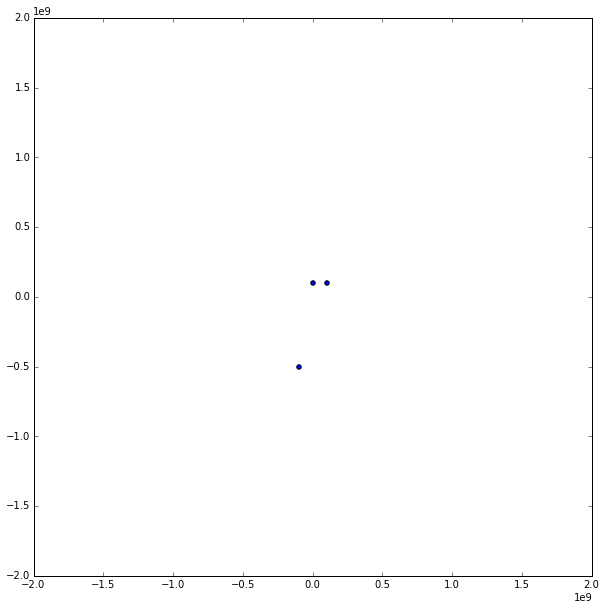

In [63]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time]
    y = ParticlePositionHistory[:,1,time]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y)
    plt.xlim(-2e9, 2e9)
    plt.ylim(-2e9, 2e9)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()